# The Memonomicon

This notebook provides a friendly introduction to memo. It is well-suited for people who already have some familiarity with the art of Bayesian modeling in cognitive science (e.g. with WebPPL). Some practice with array programming in Python (e.g. libraries like NumPy, PyTorch, or JAX) may also be helpful.

In [1]:
# !pip install memo-lang

import jax
import jax.numpy as np
from memo import memo

## Hello, memo!

At its heart, memo is a language for modeling the _choices_ made by _agents_. For example, suppose Alice chooses a card among three options, uniformly at random. Let us start by computing the expected value of the number on the card.

If we were expressing this situation in mathematical notation, we might say that Alice choses $c \sim \text{Uniform}(\text{cards})$, or perhaps $p(c) \propto 1$, and that we wish to compute $\textbf{E}[c]$.

To express this in memo, first we create a representation of the set of cards:

In [2]:
cards = np.array([1, 2, 3])

Then, we create a memo that represents Alice choosing one of the cards with uniform probability.

In [3]:
@memo
def alice_chooses_card():
    cast: [alice]
    alice: chooses(c in cards, wpp=1)
    return E[alice.c]

+ `@memo` is a tag that tells memo to interpret the function as memo code rather than Python code.
+ `cast` tells memo the names of the agents being modeled (like a cast of characters in a play). In this case, there is only one (Alice).
+ `chooses` says that Alice picks one card among `cards`, and calls that card `c`.
+ `wpp` stands for **"with probability proportional to"**. Here, Alice chooses with probability proportional to 1, i.e. uniformly at random. In general, we can write arbitrary expressions after `wpp` to express probability distributions, which memo will automatically normalize.
+ The `return` line says we should compute the expected value of Alice's card (`alice.c`).

We can run this memo by calling it just like a Python function.

In [4]:
alice_chooses_card()

Array(2., dtype=float32)

The return value is a JAX array, which indeed contains 2, the average card value.

## Array programming in memo

Another way to think about memo is as a language for _defining tables of values_. For example, suppose we wanted to create a table that shows the probability that Alice chooses each card. We could do this by introducing a new **axis** to our memo `alice_chooses_card[c: card]`), and `return`-ing the probability that Alice's chosen card is `c` (given by `E[alice.c == c]`).

You can think of introducing an axis as saying: "for every possible value of `c` in `cards`, run this model and give me the outputs in a table."

In [5]:
@memo
def alice_chooses_card[c: cards]():  # notice the new axis c
    cast: [alice]
    alice: chooses(c in cards, wpp=1)
    return E[alice.c == c]

alice_chooses_card()

Array([0.33333334, 0.33333334, 0.33333334], dtype=float32)

The result is what we expect: a uniform distribution, 1/3 probability each. Because the result is just a Python array, we can directly visualize this distribution using matplotlib.

Text(0.5, 1.0, "Alice's choice")

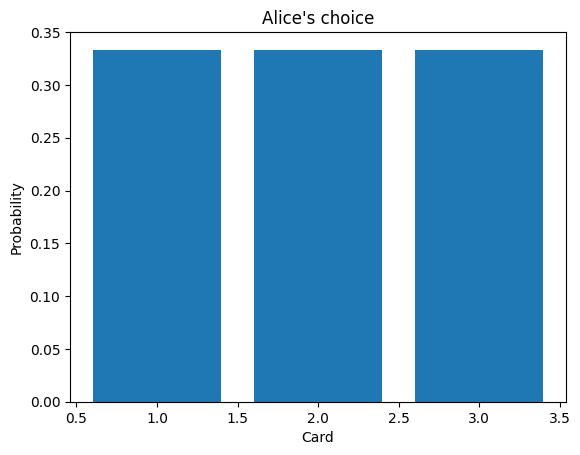

In [6]:
from matplotlib import pyplot as plt
plt.bar(cards, alice_chooses_card())
plt.xlabel('Card'); plt.ylabel('Probability'); plt.title("Alice's choice")

Let's try a more interesting distribution. Suppose Alice is likelier to pick a card with a higher value: for example, suppose $p(c) \propto \exp(\beta \cdot c)$, i.e. Alice chooses based on a softmax over card values with some temperature $\beta$. We can model this in memo by introducing a **parameter** `beta`, and editing the `wpp` of Alice's choice accordingly.

Notice that **axes** like `c` appear in square brackets and **parameters** like `beta` appear in round parentheses in the definition of a memo. These are different! You should think of axes as representing the combinatorial space of possible conditions/scenarios/outcomes of an experiment (square brackets ~ discrete tabular), and parameters as free parameters of the model (round parentheses ~ continuous knobs).

Our new model, run with $\beta = 3$, shows that Alice is overwhelmingly likelier to choose card 3 than either card 1 or card 2. She is also much likelier to choose card 2 over card 1.

Text(0.5, 1.0, "Alice's choice")

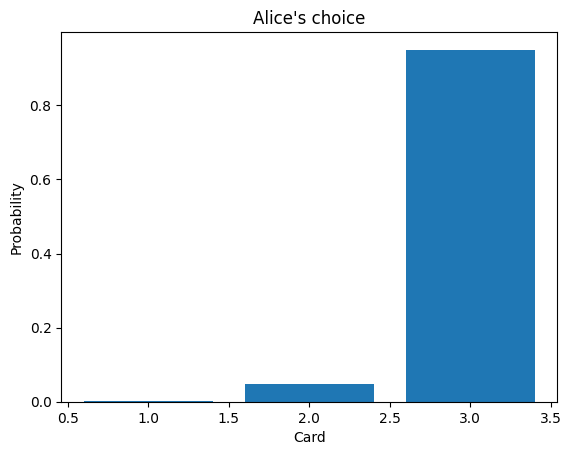

In [7]:
@memo
def alice_chooses_card[c: cards](beta):  # notice the new parameter beta
    cast: [alice]
    alice: chooses(c in cards, wpp=exp(beta * c))  # notice new wpp
    return E[alice.c == c]

plt.bar(cards, alice_chooses_card(3.0))
plt.xlabel('Card'); plt.ylabel('Probability'); plt.title("Alice's choice")

Now, let's introduce a new agent. Suppose Bob also wants to choose a card — he doesn't care about the value, but he wants to avoid choosing the same card as Alice.

First, take a moment to test your intuition: what do you expect? Knowing what he does about Alice, Bob will undoubtedly avoid card 3. We should therefore expect him to probably pick card 1 or card 2, with a slight preference for card 1.

To model this in memo, we create a new memo called `bob_chooses_card`, where the cast includes both Alice and Bob. Then, we use the **thinks** statement to express _Bob's mental model of Alice_. Notice that Alice's `wpp` references the `alice_chooses_card` memo we defined above, with $\beta=3$. Importantly, Bob doesn't _know_ what Alice's card is: internally, memo models Bob's uncertainty over Alice's choice.

Finally, we model Bob's choice as avoiding Alice's choice (`wpp=E[~(c == alice.c)]`). Notice that we need the expected value because Bob doesn't know `alice.c`. Finally, we compute a probability distribution over Bob's card choices as before (`E[bob.c == c]`).

Text(0.5, 1.0, "Bob's choice")

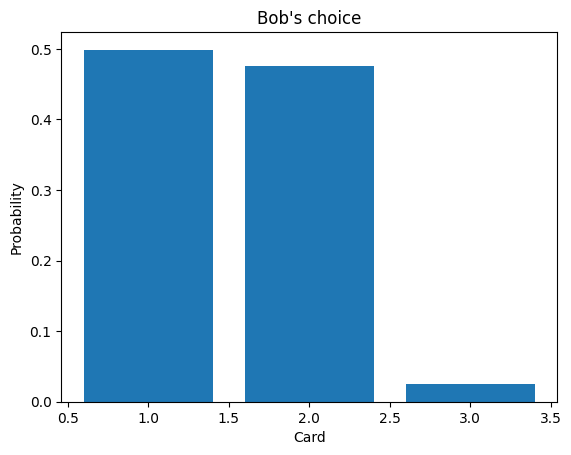

In [8]:
@memo
def bob_chooses_card[c: cards]():
    cast: [alice, bob]
    bob: thinks[  # Bob's mental model of Alice
        alice: chooses(
            c in cards,
            wpp=alice_chooses_card[c](3.0)  # reference previous memo
        )
    ]

    # Bob avoids Alice's card
    bob: chooses(c in cards, wpp=E[~(c == alice.c)])
    return E[bob.c == c]
plt.bar(cards, bob_chooses_card())
plt.xlabel('Card'); plt.ylabel('Probability'); plt.title("Bob's choice")

This is indeed the result we expect: Bob is roughly ambivalent between cards 1 and 2, but avoids card 3.

Let us finish this section by visualizing the full matrix of possible game outcomes as a heatmap. We'll do this by creating a memo with _two_ axes: one for Alice's card and one for Bob's card.

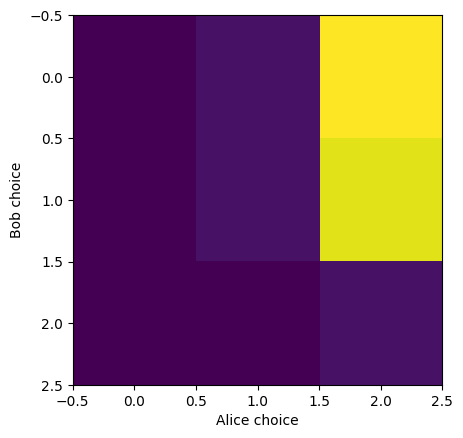

In [9]:
@memo
def all_outcomes[a: cards, b: cards]():
    cast: [alice, bob]
    alice: chooses(c in cards, wpp=alice_chooses_card[c](3.0))
    bob: chooses(c in cards, wpp=bob_chooses_card[c]())
    return E[alice.c == a and bob.c == b]

plt.imshow(all_outcomes())
plt.xlabel('Alice choice')
plt.ylabel('Bob choice')
None

## Scalar implicature

Now that you have some experience with memo, let us try a more sophisticated model: a simple Bayesian model of scalar implicature. Suppose your friend points to a group of three people and says "some of those people are nice." Even though that statement is logically consistent with all 3 people being nice, you intuitively interpret it as 1 or 2 people being nice, because if _all_ of the people were nice, your friend would have said "all" rather than "some."

To model this kind of inference in memo, we start by creating sets representing $N$, the number of nice people, and $U$, the possible utterances your friend could have made ("none," "some," or "all" of the people are nice).

In [10]:
N = [0, 1, 2, 3]  # number of nice people
U = [0, 1, 2]     # utterance: {none, some, all} of the people are nice

Next, we write a function that returns `True` if an utterance `u` is logically consistent with a number `n`, and `False` otherwise. We decorate this function with `@jax.jit`, which makes it a fast JAX-compiled function.

(For efficiency reasons, memo can only make calls to JAX functions. But JAX can be used to write nearly any program you can imagine, including physics simulators, graphics engines, neural networks, and more.)

In [11]:
@jax.jit
def meaning(n, u):  # (none)  (some)  (all)
    return np.array([ n == 0, n > 0, n == 3 ])[u]

Finally, we write a memo that involves a `speaker` and a `listener`. Notice the two axes: we will ultimately produce a table that gives the listener's posterior belief for each number `n` if they heard utterance `u`. Hence, we expect the output to be a $3 \times 4$ table.

In [12]:
@memo
def scalar[n: N, u: U](beta):
    cast: [speaker, listener]
    listener: thinks[
        speaker: given(n in N, wpp=1),
        speaker: chooses(u in U, wpp=imagine[
            listener: knows(u),
            listener: chooses(n in N, wpp=meaning(n, u)),
            exp(beta * E[listener.n == n])
        ])
    ]
    listener: observes [speaker.u] is u
    listener: chooses(n in N, wpp=E[speaker.n == n])
    return E[listener.n == n]

Notice the two nested layers of recursion. The "outer" listener thinks the speaker is communicating strategically by internally imagining a naive "inner" listener. Some things to notice here:
1. `given` is an alias of `choose`, useful in cases where you don't want to imply agency.
2. `wpp=imagine[ ... ]` allows the speaker to simulate a hypothetical scenario where they chose utterance `u`. The first two lines of the `imagine` simulate what happens next, and the last line is a quantity to compute in the imagined world.
3. `knows` is used to tell an imagined agent about some value. Here, the speaker uses `knows` to tell the imagined listener about the chosen utterance.
4. `observes` is used to condition on an observation of another agent's choice. Here, the listener observes that the speaker's chosen `u` is `u`.

Running this model with $\beta=6$ gives us the following $3\times 4$ table:

In [13]:
scalar(1)

Array([[0.4234105 , 0.2164377 , 0.2164377 , 0.14371407],
       [0.16217656, 0.31449857, 0.31449857, 0.20882624],
       [0.15905735, 0.22101384, 0.22101384, 0.39891493]], dtype=float32)

To get a better sense for this, we can plot it with matplotlib. Do our general expected patterns seem to hold?

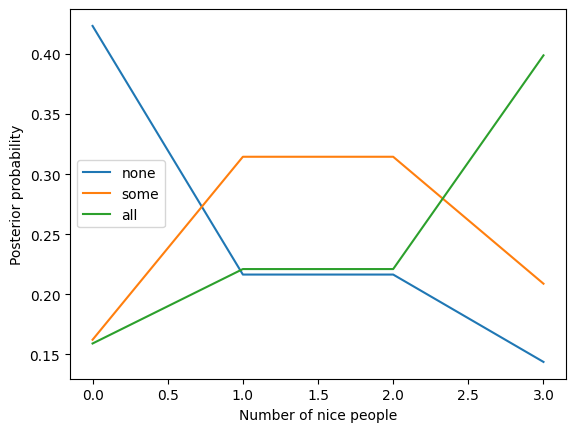

In [14]:
from matplotlib import pyplot as plt
plt.plot(scalar(1).T, label=['none', 'some', 'all'])
plt.xlabel('Number of nice people')
plt.ylabel('Posterior probability')
plt.legend()

## Fitting parameters

Suppose we collected some data on people's intuitions about scalar implicature:

In [15]:
# (this is fake data for the sake of a tutorial)
data = np.array([
    [0.95, 0.05, 0., 0.],
    [0., 0.4, 0.6, 0.],
    [0., 0., 0.05, 0.95]
])

We can compare our model's fit to the data by plotting a scatterplot:

Text(0, 0.5, 'Humans')

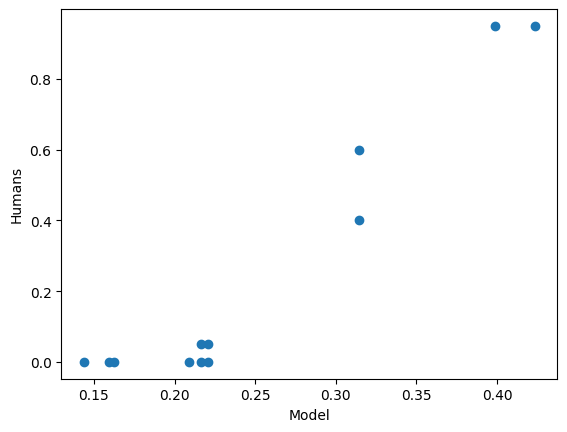

In [16]:
plt.scatter(scalar(1).reshape(-1), data.reshape(-1))
plt.xlabel('Model')
plt.ylabel('Humans')

We can probably get a better fit by tuning the $\beta$ parameter. Fortunately, because memo is based on JAX, we have many powerful optimization tools at our disposal. Let's start by writing down a loss function to optimize: say, mean squared error.

In [17]:
@jax.jit
def mse(beta):
    return np.mean((data - scalar(beta)) ** 2)
mse(1)

Array(0.07819292, dtype=float32)

Looks like our MSE is currently quite high, but perhaps we can do better. We will optimize the MSE two ways: by grid search and by gradient descent.

### Grid search

JAX makes it easy and fast to perform a parallelized grid search over possible $\beta$ values. Here is a near-instantaneous grid search over 1000 options. Notice the use of JAX's `vmap` to parallelize the grid search.

CPU times: user 89 ms, sys: 5.52 ms, total: 94.5 ms
Wall time: 89.6 ms


Text(0.5, 0, 'beta')

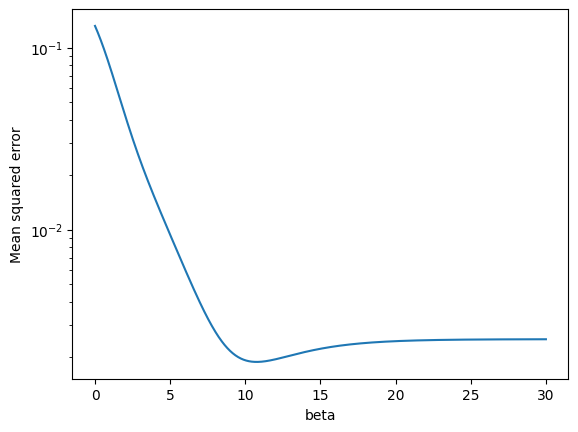

In [18]:
%%time
beta_grid = np.linspace(0, 30, 1000)
plt.plot(beta_grid, jax.vmap(mse)(beta_grid))
plt.yscale('log')
plt.ylabel('Mean squared error')
plt.xlabel('beta')

It looks like the minimum is near 10. Let's try to get a more precise answer by gradient descent, starting from $\beta=10$. The key trick here is to use `jax.value_and_grad`, which returns a tuple of a functions value and its derivative with respect to its inputs. That derivative can then be used for gradient descent.

Final beta value: 10.7509985
Final MSE: 0.0018750217


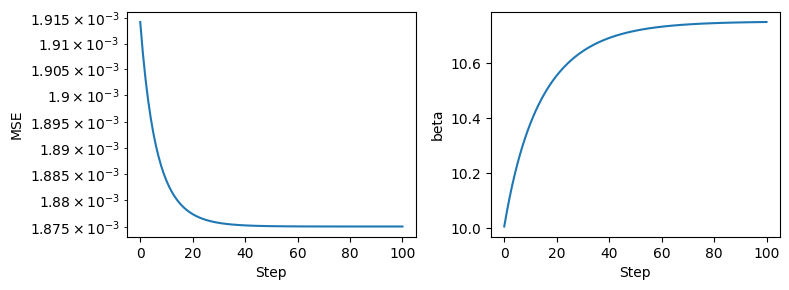

In [19]:
grad = jax.value_and_grad(mse)

beta = 10.
betas = []
mses = []
for t in range(1_000 + 1):
    mse_value, mse_grad = grad(beta)
    beta = beta - 50. * mse_grad
    if t % 10 == 0:
        betas.append(beta)
        mses.append(mse_value)

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(mses)
plt.xlabel('Step')
plt.ylabel('MSE')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(betas)
plt.xlabel('Step')
plt.ylabel('beta')

plt.tight_layout()

print("Final beta value:", beta)
print("Final MSE:", mse_value)

That's a much lower MSE than what we started with! To finish up, let us make a scatterplot with our optimized model.

Text(0, 0.5, 'Humans')

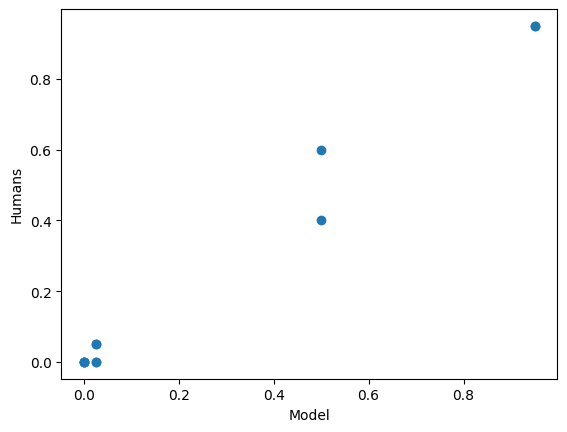

In [20]:
plt.scatter(scalar(beta).reshape(-1), data.reshape(-1))
plt.xlabel('Model')
plt.ylabel('Humans')